# Experiment 4:
## Reconstructing using multiple generative models

This experiment shows visual behaviour of using multiple generative models for the reconstruction of images in the MNIST data set by consider a generative model for each label.

In [1]:
import numpy as np;
import numpy.linalg as linalg;

import matplotlib.pyplot as plt;
from matplotlib.pyplot import figure;

import torch;
import torch.nn as nn;
import torch.nn.functional as F;
import torch.optim as optim;

from torch.utils.data import DataLoader;
import torchvision;

import pickle;

import time;
import random;
import math;

from IPython.display import clear_output;

import MNIST_utils as MNIST;
import MNIST_generative as generative;
import sparsity_utils as sparsity;
import general_utils as utils;

In [2]:
(train_data, test_data), (train_loader, test_loader) = MNIST.load_dataset();

mspace = [10,20,30,50,100];
noise = 0.1;

In [3]:
utils.reset_seeds();

networks = [generative.createNetwork(2, 20)[1] for i in range(10)];
for i in range(10):
    generative.trainNetwork(networks[i], MNIST.getTrainLoader(i), num_epochs = 20);

C:\Users\jever\anaconda3\lib\site-packages\torch\nn\functional.py:1709: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Epoch: 1 	 Train_loss: 1.723460
Epoch: 2 	 Train_loss: 0.883920
Epoch: 3 	 Train_loss: 0.676205
Epoch: 4 	 Train_loss: 0.573890
Epoch: 5 	 Train_loss: 0.532270
Epoch: 6 	 Train_loss: 0.500841
Epoch: 7 	 Train_loss: 0.477485
Epoch: 8 	 Train_loss: 0.461685
Epoch: 9 	 Train_loss: 0.449563
Epoch: 10 	 Train_loss: 0.439225
Epoch: 11 	 Train_loss: 0.430061
Epoch: 12 	 Train_loss: 0.421348
Epoch: 13 	 Train_loss: 0.413417
Epoch: 14 	 Train_loss: 0.405781
Epoch: 15 	 Train_loss: 0.398366
Epoch: 16 	 Train_loss: 0.391080
Epoch: 17 	 Train_loss: 0.384265
Epoch: 18 	 Train_loss: 0.378158
Epoch: 19 	 Train_loss: 0.372938
Epoch: 20 	 Train_loss: 0.368019
Epoch: 1 	 Train_loss: 0.894575
Epoch: 2 	 Train_loss: 0.304128
Epoch: 3 	 Train_loss: 0.190477
Epoch: 4 	 Train_loss: 0.153367
Epoch: 5 	 Train_loss: 0.128417
Epoch: 6 	 Train_loss: 0.113783
Epoch: 7 	 Train_loss: 0.105194
Epoch: 8 	 Train_loss: 0.098665
Epoch: 9 	 Train_loss: 0.092711
Epoch: 10 	 Train_loss: 0.087561
Epoch: 11 	 Train_loss: 0.08

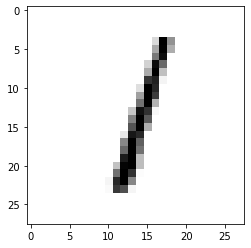

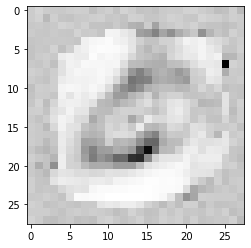

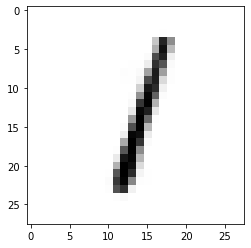

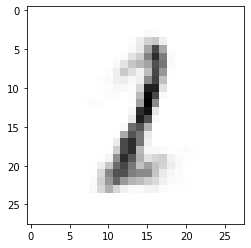

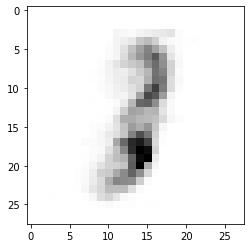

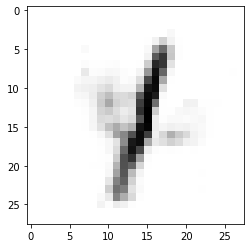

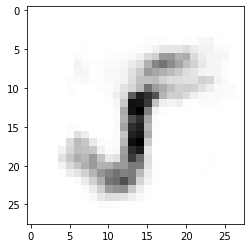

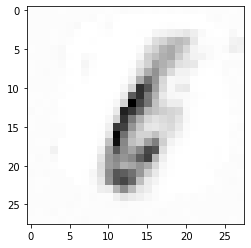

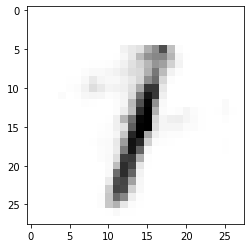

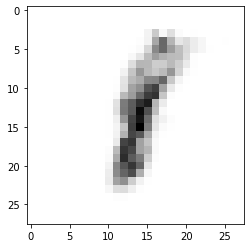

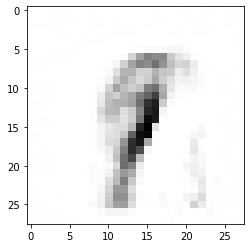

0 : 1.1864257
1 : 0.12309178
2 : 0.5168653
3 : 0.7633958
4 : 0.4798773
5 : 0.70321757
6 : 0.90232795
7 : 0.4411229
8 : 0.585188
9 : 0.7497345


In [9]:
x_true = MNIST.getImageAsVector(test_loader,2);
plt.imshow(MNIST.VectorToImage(x_true), cmap="binary");
plt.show();

imgs = [];

utils.reset_seeds();
for i in range(10):
    img =  generative.project(x_true, networks[i],
                              num_epochs = 200,
                              learning_rate = 0.0001);
    
    plt.imshow(MNIST.VectorToImage(img), cmap="binary");
    plt.show();
    imgs.append(img);

best_data = [() for i in range(10)];
for i in range(10):
    true_error = linalg.norm(utils.normalize(imgs[i])-utils.normalize(x_true));
    best_data[i] = (imgs[i], true_error);
    print(str(i) + " : " + str(true_error));

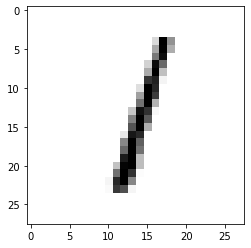

10 0 1.1084827 0.0
10 1 1.1600915 0.0
10 2 1.1373461 0.0
10 3 1.0954036 0.0
10 4 1.1747338 0.0
10 5 1.214643 0.0
10 6 1.1208528 0.0
10 7 1.2065012 0.0
10 8 1.1976893 0.0
10 9 1.1942606 0.0
20 0 1.1456877 0.0
20 1 1.1582018 0.0
20 2 1.0792452 0.0
20 3 1.1510628 0.0
20 4 1.1392978 0.0
20 5 1.2415589 0.0
20 6 1.2496814 0.0
20 7 1.0843004 0.0
20 8 1.2650554 0.0
20 9 1.3013529 0.0
30 0 1.30438 9.36786263511974
30 1 0.6170744 0.0
30 2 0.7779173 0.37930636360568276
30 3 1.1116645 1.9200729051716974
30 4 0.9434422 0.008647559775497138
30 5 1.0702242 1.1207925951816922
30 6 1.1892152 2.6154557637671476
30 7 0.54726756 0.18784231847689528
30 8 1.0617257 0.9448760127893302
30 9 0.9910851 1.2715945560567687
50 0 1.1463997 5.594584486378108
50 1 0.7831152 0.0
50 2 0.7681997 1.48782702005705
50 3 1.0188258 5.867103762098068
50 4 0.78402233 0.0604582611604321
50 5 1.0478238 2.409387751282014
50 6 0.9950433 5.039234837934798
50 7 0.6417385 0.0
50 8 0.80390906 0.7737808676110918
50 9 1.1030786 1.996660

In [5]:
x_true = MNIST.getImageAsVector(test_loader,2);
plt.imshow(MNIST.VectorToImage(x_true), cmap="binary");
plt.show();

data = [[() for i in range(10)] for m in mspace];
utils.reset_seeds();
for j in range(len(mspace)):
    m = mspace[j];

    A, q = utils.generateMeasurements_Gaussian(x_true, m, noise);
    q = utils.quantize(q);


    for i in range(10):
        projector =  lambda x : generative.project(x,networks[i],
                                 num_epochs = 50, learning_rate = 0.01);
    
    
        best = 10000;
        best_obj = 100000;
        y_best = ();
        rep = 3;
        for k in range(rep):
            y, accuracy = MNIST.reconstruct_BIP(A, q, x_true, projector,
                                           learning_param = 0.04, iterations = 50);
            
            inter = np.multiply(A.dot(utils.normalize(y)),q);
            inter = [min(z, 0) for z in inter];
            inter = linalg.norm(inter, ord=1)
            if inter < best_obj:
                best_obj = inter;
                best = accuracy;
                y_best = y;


        data[j][i] = (y_best, best_obj, linalg.norm(utils.normalize(x_true)-utils.normalize(y_best)));
        print(str(m)+" "+str(i) + " " + str(best) + " " + str(best_obj));
    

In [6]:
thresholds = [[] for i in range(len(mspace))];
for i in range(len(mspace)):
    objs = [d[1] for d in data[i]];
    thresholds[i] = min(objs);
    
print(thresholds);

[0.0, 0.0, 0.0, 0.0, 0.0]


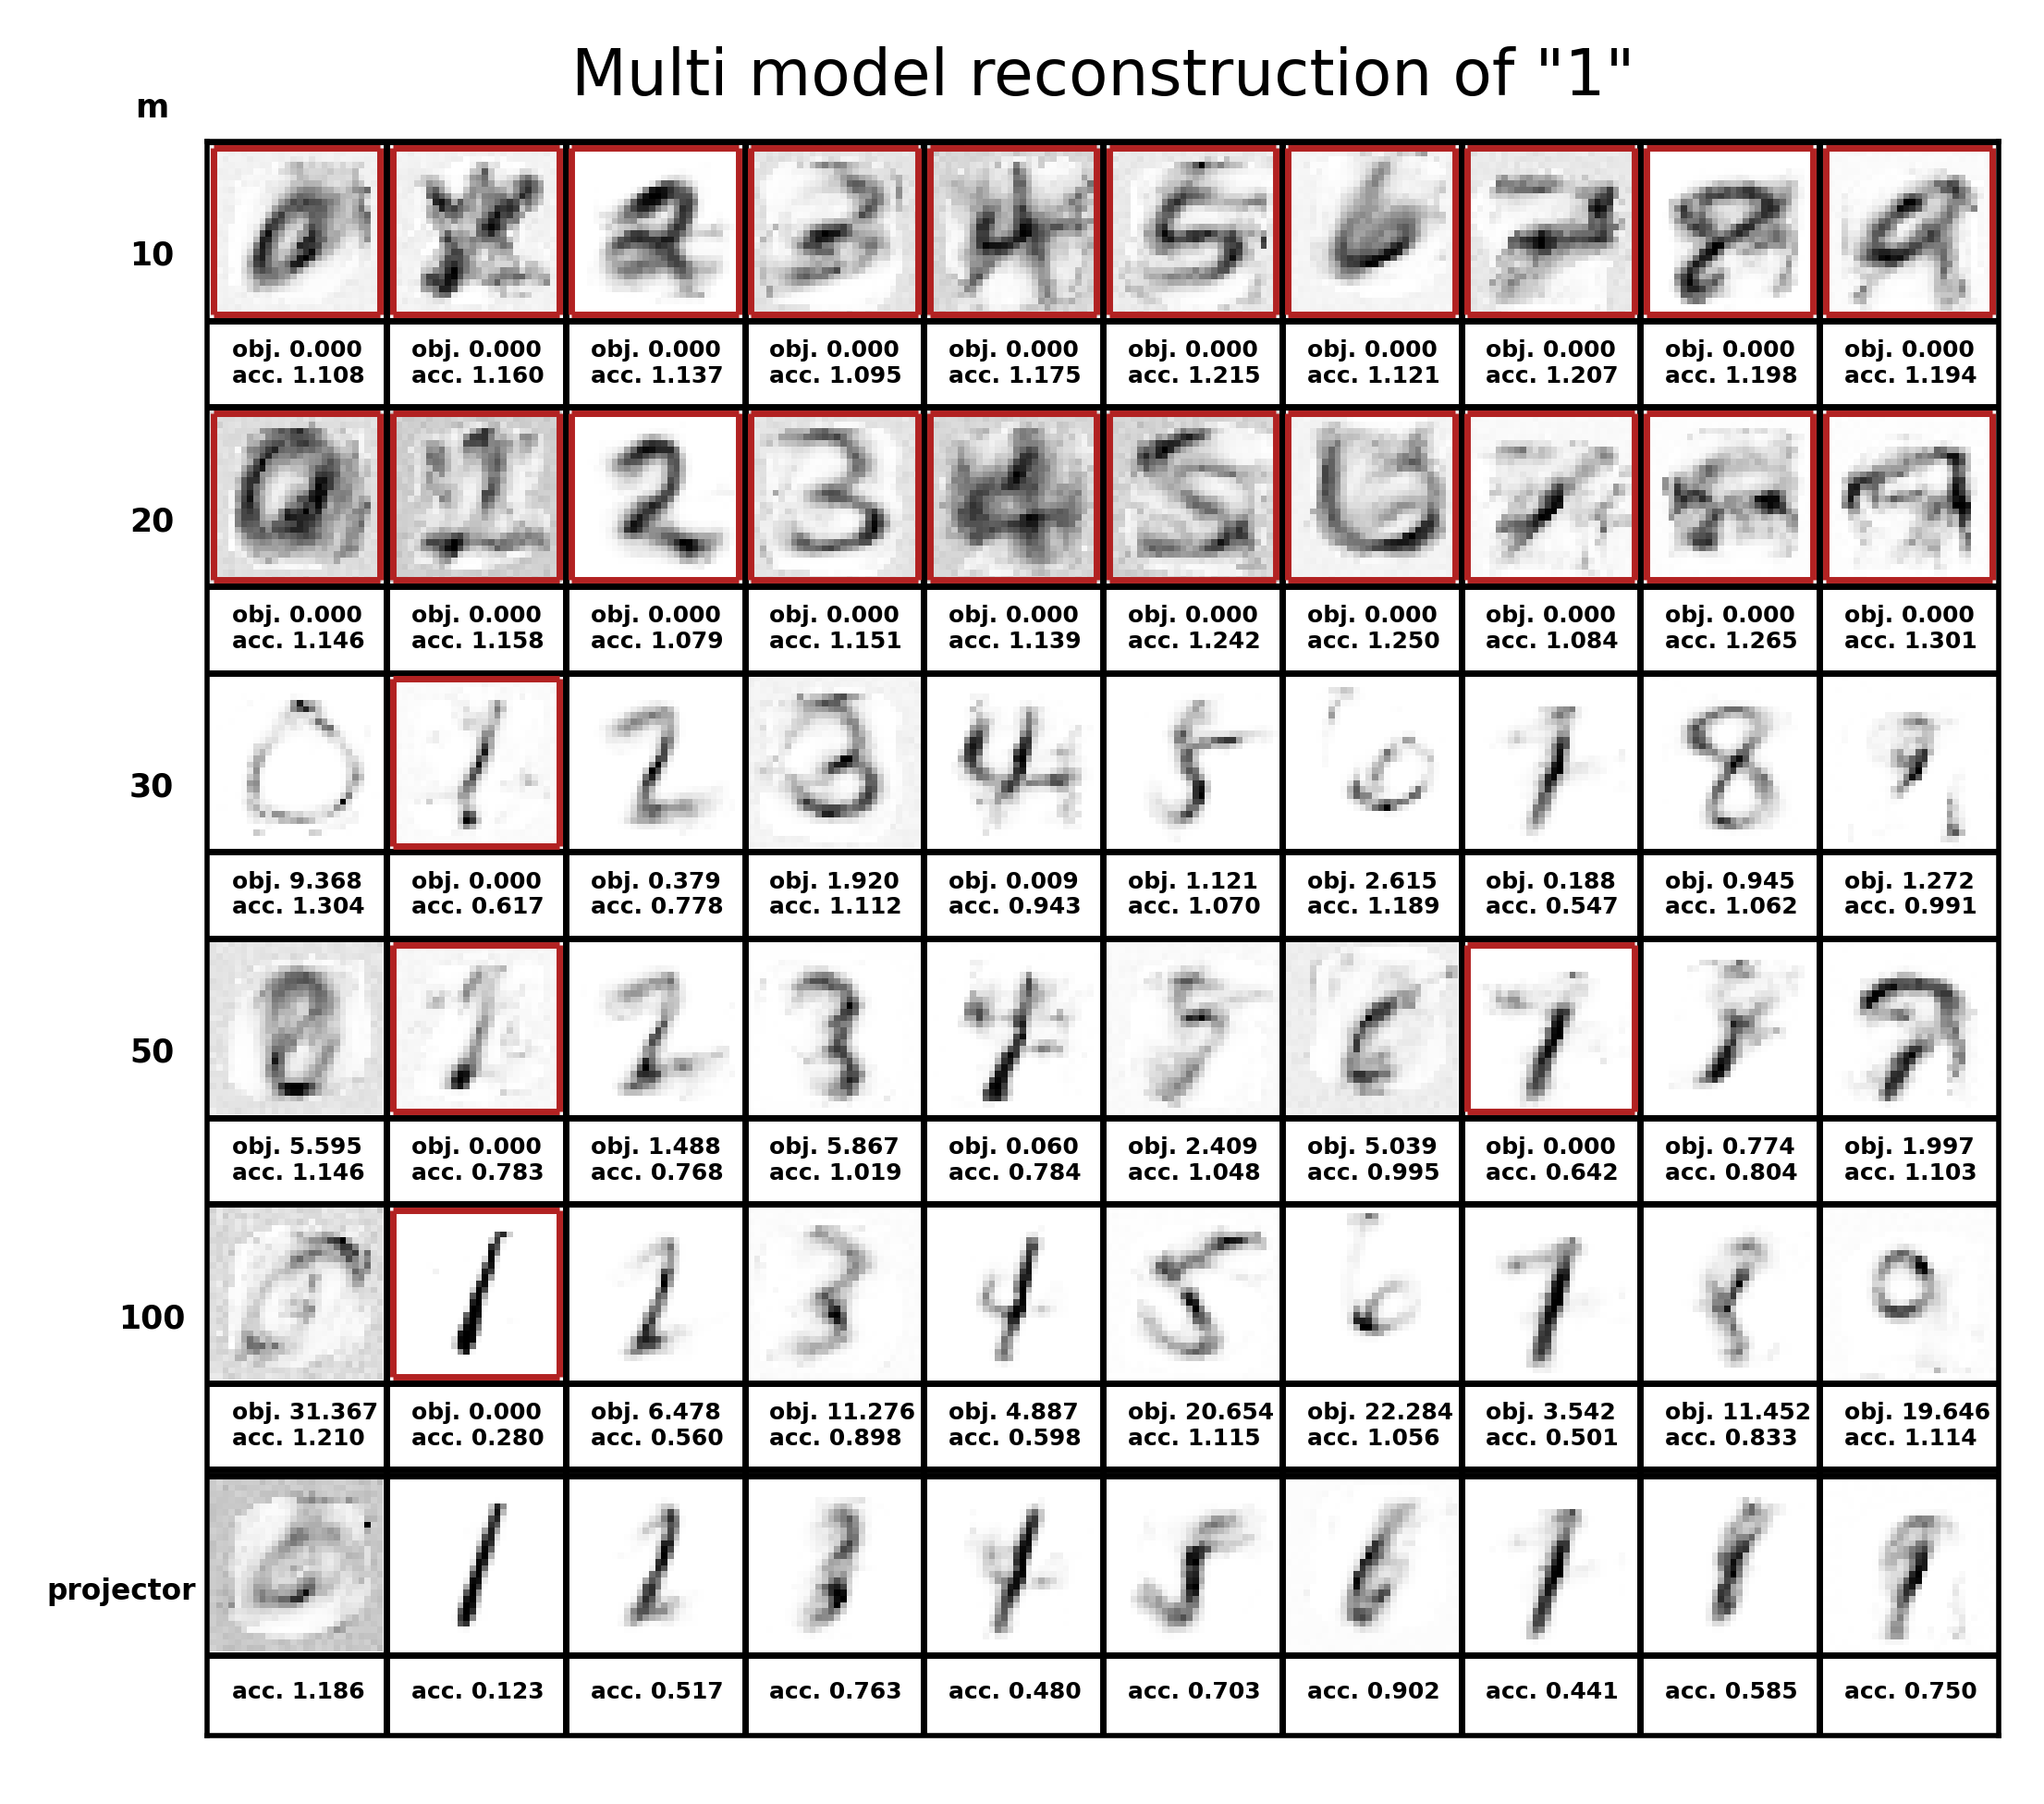

In [7]:
accheight = 14;
models = len(networks);

filterindices = [0,1,2,3,4]
ms = len(filterindices);

results = np.zeros(((28+accheight+1)*(ms + 1),(models)*(28+1)));
figure(figsize=(5, 5), dpi=500);

def drawBorder(x1,y1,x2,y2,color):
    plt.vlines([x1,x2-1],y1,y2-1, colors=color, linewidth=1);
    plt.hlines([y1,y2-1],x1,x2-1, colors=color, linewidth=1);
    
for i in range(ms):
    for j in range(models):
        image = data[filterindices[i]][j][0];
        image = np.abs(image);
        image = image/np.max(image);
        results[(28+accheight+1)*i+1:(28+accheight+1)*i+28+1,(28+1)*j+1:(28+1)*j+28+1] = MNIST.VectorToImage(image);
        
for j in range(models):   
    best_img = MNIST.VectorToImage(best_data[j][0]);
    best_img = np.abs(best_img);
    best_img = best_img/np.max(best_img);
    offset = (28+accheight+1)*ms + 2;
    results[offset:offset+28,(28+1)*j+1:(28+1)*j+28+1] = best_img;
    
plt.imshow(results, cmap='binary');
plt.xticks([]);
plt.yticks([]);
plt.ylim([((28+accheight+1)*(ms+1)),0]);
plt.xlim([0, (models)*(28+1)-1 + 1]);

plt.hlines([i*(28+accheight+1) for i in range(ms+1)],0,(models)*(28+1), colors='black', linewidth=1);
plt.hlines([i*(28+accheight+1)-accheight for i in range(ms+1)],0,(models)*(28+1), colors='black', linewidth=1);

plt.vlines([i*(28+1) for i in range(1,(models))],0,((28+accheight+1)*(ms+1) + 2) - 1, colors='black', linewidth=1);

plt.hlines([(ms)*(28+accheight+1) + 1],0,(models)*(28+1), colors='black', linewidth=1);
plt.hlines([(ms+1)*(28+accheight+1)-accheight+1],0,(models)*(28+1), colors='black', linewidth=1);

for i in range(ms):
    for j in range(models):
        string = "obj. {:.3f}".format(data[filterindices[i]][j][1]) + "\n" + "acc. {:.3f}".format(data[filterindices[i]][j][2]);
        plt.text((28+1)*j + 4, -4 + ((i+1)*(28+1+accheight)), string, fontsize=3.6, fontweight="bold", ha="left");

for j in range(models):
    string = "acc. {:.3f}".format(best_data[j][1]);
    plt.text((28+1)*j + 4, -8 + (28+accheight+1)*(ms+1) + 2, string, fontsize=3.6, fontweight="bold", ha="left");

for i in range(ms):
    plt.text(-9, (28+accheight+1)*i + 20, str(mspace[filterindices[i]]), fontsize=5.0, fontweight="bold", ha="center");
plt.text(-9, -4, "m", fontsize=5.0, fontweight="bold", ha="center");
plt.text(-14, (28+accheight+1)*(ms) + 21, "projector", fontsize=4.5, fontweight="bold", ha="center");
    
for i in range(ms):
    for j in range(models):
        if data[i][j][1] <= thresholds[i]:
            drawBorder((28+1)*j + 1,(28+accheight+1)*i + 1, (28+1)*j+28 + 1,(28+accheight+1)*i+28 + 1, "firebrick");
    
plt.rcParams['axes.titley'] = 1.005;
plt.title("Multi model reconstruction of \"1\"", fontsize = 10);
plt.savefig("results_images\images_multi_model_half_k20.png", dpi=1000);